# 共通テストをD-Waveマシンで解く

## 概要

現在の大学入試共通テストでは、マーク式問題が採用されています。記述式問題を取り入れることも検討されましたが、採点方法等の理由で取り下げられたことは記憶に新しいと思います。マーク式問題のデメリットは、分からない問題でも一定の確率で正解になってしまうことです。裏を返せば、問題文を見ることなく正解することも可能だということです。本記事では、D-Waveマシンを使って問題文を見ることなく共通テストを解いてみせましょう。

## 方法

### ブラックボックス最適化とは

問題文を見ずに解くと言っても、ヒント無しで満点を取るのは困難でしょう。そこで、採点は何回でも行えることにします。ただし、採点の過程がブラックボックスになっており、どの問題が正解なのかは明かされません。あくまでも点数のみが情報として与えられることにします。「マークした番号」と「合計点数」という入出力情報のみを用いて満点の解答を探しだします。

<img src="figures/overview.png" width="50%">

このように、合計点数を最大化(または最小化)することを**ブラックボックス最適化**と言います。まずは、解答用紙をコンピュータが認識できる形に変換しましょう。マークした番号を「１」それ以外を「0」で表せば良さそうです。このような制約を**one-hot制約**と言います。

<img src="figures/scorring_overview.png" width="70%">

ここで、ブラックボックスになっている採点の過程を関数$f\left(\vec{x}\right)$と置くことにします。$f\left(\vec{x}\right)$はどのような形になりそうでしょうか。単純に、正解ベクトルと入力ベクトルの内積で正解数を表せると思うかもしれません。しかし、２個以上マークした解答は不正解となるため、そのように表すことは出来ません。

$$
\left\{\begin{array}{l}
\text { 正解: } \vec{c}=(0,1,0,0) \\
\text { 入力: } \vec{x}=(0,1,0,1)
\end{array}\right.
$$

$$
\vec{c} \cdot \vec{x}=1 \neq 0
$$


つまり、$f\left(\vec{x}\right)$にはone-hot制約が必要です。従って、真の関数は次のようになると予想できます。

$$
\max \quad f(\vec x) = \sum_{i}^N \sum_{j}^N c_{ij} x_{i}x_{j} - \left(\sum_{i=0}^3 x_{i} - 1\right)^2-\cdots
$$

第2項以降は、one-hot制約を表しています。ここで、回答者は$c_{ij}$が分からないためブラックボックスとなっているのです。そこで、上記の第1項部分を以下のQUBOで表しましょう。

$$
\max \quad g\left(\vec{x}\right) = \sum_{i=1}^N \sum_{j=1}^N Q_{i j} x_{i} x_{j}+Q_{0}
$$

ここで、Nは$(設問数)\times(選択肢の数)$で、$Q_{0}$は定数項です。また、QをQUBO行列と呼び、$g\left(\vec{x}\right)$を**代理関数**と呼びます。ここからは、真の関数の第1項を学習していきます。

$g\left(\vec{x}\right)$をQUBOで表したのは、D-Waveマシンで解ける形にするためです。しかし、このままでは少し複雑なので、より簡単な線形モデルに変形させましょう。そのために、次の変換を行います。

$$
\vec{X}:=\left(1, x_{1}, x_{2}, \ldots, x_{N}, x_{1} x_{2}, x_{1} x_{3}, \ldots, x_{N-1} x_{N}\right)^\mathsf{T}\\
\vec{a} := \left( Q_{0}, Q_{11}, \ldots, Q_{NN}, Q_{12}, Q_{13}, \ldots, Q_{N-1, N}\right)^\mathsf{T}
$$


QUBOを線形モデルに変形する過程は次の通りです。

$$
\begin{equation}
\begin{split}
g(\vec{x}) &= \sum_{i}^N \sum_{j}^N Q_{i j} x_{i} x_{j} + Q_0\\
&=Q_{0}+Q_{11} x_{1}+Q_{22} x_{2}+\ldots Q_{NN} x_{N}+Q_{12} x_{1} x_{2}+Q_{13} x_{1} x_{3}+\ldots+Q_{N-1, N} x_{N-1} x_{N}\\
&=a_{0}+a_{1} x_{1}+a_{2} x_{2}+\ldots a_{N} x_{N}+a_{12} x_{1} x_{2}+a_{13} x_{1} x_{3}+\ldots+a_{N-1, N} x_{N-1} x_{N}\\
&=\sum_{k} a_{k} X_{k}=\vec{a}^\mathsf{T}\vec{X}
\end{split}
\end{equation}
$$

これで、代理関数を線形モデルに変換できました。$\vec{a}$は、$\vec{X}$ の係数部分になっていることが分かります。従って、$\vec{a}$を調整することにより、$g(\vec{x})$を真の関数$f\left(\vec{x}\right)$に近づけることが出来ます。それでは、$\vec{a}$を調整する方法を考えていきましょう。

### ベイス推論とは

事前に与えられている情報は、「マークした番号」と「合計点数」のみです。
これらの入出力データを$(\vec{x}, y)$として$\vec{a}$を推定してみましょう。

まずは、**ベイズの定理**について確認します。

$$
P(A \mid B)=\frac{P(B \mid A) P(A)}{P(B)}
$$

これは、３変数の場合でも同様に成り立ちます。

$$
P(A \mid B, C)=\frac{P(B \mid A, C) P(A, C)}{P(B, C)}
$$

我々の目的は、入出力データ$(\vec{x}, y)$から$\vec{a}$を推定することです。そこで、ベイズの定理から次の条件付き確率を考えてみましょう。

$$
P\left(\vec{a} \mid y, \vec{x}\right)=\frac{P\left(y \mid \vec{a}, \vec{x}\right) P\left(\vec{a}\right)P\left(\vec{x}\right)}{P\left(y, \vec{x}\right)}
$$

ここで、$\vec{a}$と$\vec{x}$は独立のため、$P\left(\vec{a}, \vec{x}\right)=P\left(\vec{a}\right)P\left(\vec{x}\right)$の関係を使いました。


$P(\vec{a} \mid y, \vec{x})$は、$(\vec{x}, y)$が与えられたときの$\vec{a}$に対する確率と読みます。$\vec{a}$という原因によってデータ$(\vec{x}, y)$が得られると考えると、事象が起きた後の確率を表しているので、**事後確率**と言います。一方、$P(\vec{a})$は事象が起きる前の確率なので**事前確率**と言い、$\vec{a}$が選ばれる確率を表しています。

我々が知りたいのは、事後確率が最も高くなるときの$\vec{a}$です。そこで、微分して0となる$\vec{a}$を計算することにしましょう。しかし、事後確率は微分しづらい積の形をしているので対数を取ることで、和の形に変形しましょう。

$$
\begin{equation}
\begin{split}
\log P\left(\vec{a} \mid y, \vec{x}\right)&=\log \frac{P\left(y \mid \vec{a}, \vec{x}\right) P\left(\vec{a}\right)P\left(\vec{x}\right)}{P\left(y, \vec{x}\right)}\\
&=\log P\left(y \mid \vec{a}, \vec{x}\right)+\log P\left(\vec{a}\right) +\log P\left(\vec{x}\right) - \log P\left(y, \vec{x}\right)
\end{split}
\end{equation}
$$

$\vec{a}$に関する部分のみ残すと、最終的な式は次のようになります。

$$
\vec{a}=\underset{\vec{a}}{\arg \max }\left\{ \log P\left(y \mid \vec{a}, \vec{x}\right)+\log P\left(\vec{a}\right)\right\}
$$

このように、ベイズの定理を利用してパラメータを推定する手法の１つを**最大事後確率（maximum a posteriori, MAP）推定**といいます。それでは、実際に$P\left(y \mid \vec{a}, \vec{x}\right)$と$P\left(\vec{a}\right)$を代入して計算していきましょう。

### MAP推定

$P\left(  y \mid \vec{a}, \vec{x}\right)  $を導出します。まず、真の関数$f\left(  \vec{x}\right)  $と代理関数$g\left(  \vec{x}\right)  $の間には誤差が生じると考えます。全データに対する誤差の総和を$z$とすると、次のように定義できます。

$$
z := \sum_{d=1}^D \left(  f\left(  \vec{x }_d\right)   - g\left(  \vec{x}_d\right)  \right)   = \sum_{d=1}^D \left(  y_d - \vec{a}^\mathsf{T}\vec{X}_d\right)  
$$

ここで、$D$はデータの数です。

続いて、$z$が$\mu=0, \sigma^2=1$のガウス分布に従うと仮定すると、確率密度関数は次のようになります。

$$
P(z)=\frac{1}{\sqrt{2\pi}}\exp\left(- \frac{1}{2}z^2\right)
$$

出力$y$は、$z$がどのような値を取るかの確率で決まるため、

$$
P\left(y \mid \vec{a}, \vec{x}\right)=P(z)=\frac{1}{\sqrt{2 \pi}} \exp \left\{-\frac{1}{2}\sum_{d=1}^D\left(y_d-\vec{a}^\mathsf{T}\vec{X}_d\right)^{2}\right\}
$$

となります。これで、$P\left( y \mid \vec{a}, \vec{x}\right) $を導出できました。これは、誤差の小さい$y$を出力する確率が高くなるような分布になっています。

次は、事前確率$P\left( \vec{a}\right) $です。$\vec{a}$もガウス分布に従うと仮定して、次のように表します。

$$
P\left(\vec{a}\right)=\sqrt{\frac{\lambda}{2 \pi}} \exp \left(-\frac{\lambda}{2} \vec{a}^{\top} \vec{a}\right)
$$

これらをMAP推定の式に代入してみましょう。

$$
\begin{equation}
\begin{split}
\vec{a}&=\underset{\vec{a}}{\arg \max }\left\{ \log P\left( y \mid \vec{a}, \vec{x}\right) +\log P\left( \vec{a}\right) \right\}\\
&=\underset{\vec{a}}{\arg \max }\left\{ \log \frac{1}{\sqrt{2 \pi}} \exp \left\{-\frac{1}{2}\sum_{i=1}^D\left( y_i-\vec{a}^\mathsf{T}\vec{X}_i\right) ^{2}\right\}+\log \sqrt{\frac{\lambda}{2 \pi}} \exp \left( -\frac{\lambda}{2} \vec{a}^{\top} \vec{a}\right) \right\}\\
&=\underset{\vec{a}}{\arg \max }\left\{-\frac{1}{2}\sum_{i=1}^D\left( y_i-\vec{a}^\mathsf{T}\vec{X}_i\right) ^{2}-\frac{\lambda}{2} \vec{a}^{\top} \vec{a}\right\}\\
&=\underset{\vec{a}}{\arg \min }\left\{\frac{1}{2}\sum_{i=1}^D\left( y_i-\vec{a}^\mathsf{T}\vec{X}_i\right) ^{2}+\frac{\lambda}{2} \vec{a}^{\top} \vec{a}\right\}
\end{split}
\end{equation}
$$

MAP推定は最小化問題に帰着されました。この関数を**損失関数**と言います。第1項は、最小二乗法になっています。これにより、真の関数と代理関数の差を最小にすることができます。第2項は、**$L_2$正則化項**です。これにより、係数$\vec{a}$の絶対値が小さくなり過学習を抑制できます。というのも、係数が大きいほど複雑な関数になり、過学習が起きやすくなるためです。過学習の例は下図の通りです。最小二乗法の式に$L_{2}$正則化項を加えることで、過学習を抑制する回帰を**リッジ(Ridge)回帰**と言います。

>過学習の例
![過学習の例](https://docs.aws.amazon.com/ja_jp/machine-learning/latest/dg/images/mlconcepts_image5.png)

(引用: https://docs.aws.amazon.com/ja_jp/machine-learning/latest/dg/model-fit-underfitting-vs-overfitting.html)

損失関数は、$\vec a$に関する2次関数になっています。従って、$\vec{a}$で微分して0となる点が求めたい$\vec{a}$です。まずは、表記の確認をします。分かりやすさのため、行列とベクトルの表記を区別しています。

$$
\vec{y}:=(y_1, y_2, \ldots, y_D)^\mathsf{T}\\
\vec{a}:=(a_1, a_2, \ldots, a_P)^\mathsf{T} \\
\vec{X}^{(d)}:=\left(X_{1}^{(d)}, X_{2}^{(d)}, \ldots, X_{P}^{(d)}\right)^\mathsf{T}\\
\mathbf{X} := (\vec{X}^{(1)}, \vec{X}^{(2)}, \ldots, \vec{X}^{(D)})
$$

それでは、微分して0となる$\vec{a}$を求めていきましょう。１行ずつ丁寧に変形していきます。

$$
\frac{1}{2}\sum_{d=1}^D\left(y_d-\sum _{k=1}^{P}a_kX_{k}^{(d)}\right)^{2}+\frac{\lambda}{2} \sum_{k=1}^{P}a_k^2
$$
$$
\begin{eqnarray*}
(a_{k}で微分)\quad\longrightarrow&&- \sum_{d=1}^D\left(y_d-\sum _{l=1}^{P}a_{l}X_{l}^{(d)}\right)X_{k}^{(d)}+\lambda a_k=0 　\\
\longrightarrow&&\sum_{d=1}^D\sum _{l=1}^{P}X_{ld}X_{kd}a_{l}+\lambda a_k=\sum_{d=1}^D X_{k}^{(d)}y_d \\
(両辺で\sum_{k=1}^Pをとる)\quad \longrightarrow&&\sum_{k=1}^P\sum_{d=1}^D\sum _{l=1}^{P}X_{l}^{(d)}X_{k}^{(d)}a_{l}+\sum_{k=1}^P\lambda a_k=\sum_{k=1}^P\sum_{d=1}^D X_{k}^{(d)}y_d  \\
\longrightarrow&&\mathbf{X}\mathbf{X}^{\mathsf{T}}\vec{a}+\lambda\mathbf{I}_P\vec{a}=\mathbf{X}\vec{y}\qquad(\mathbf{I}_PはP\times Pの単位行列) \\
\longrightarrow&&\left(\mathbf{X}\mathbf{X}^{\mathsf{T}}+\lambda\mathbf{I}_P\right)\vec{a}=\mathbf{X}\vec{y}\\
\longrightarrow&&\vec{a}=\left(\mathbf{X}\mathbf{X}^{\mathsf{T}}+\lambda\mathbf{I}_P\right)^{-1}\mathbf{X}\vec{y}\\
\longrightarrow&&\vec{a}=V^{-1}\mathbf{X}\vec{y}
\end{eqnarray*}
$$

ここで、$V^{-1}\mathbf{X}\vec{y}$は頂点であり、$V$は放物線の丸みを表しています。$V$が大きいと鋭く、小さいと緩やかな放物線になります。放物線が鋭い場合、求めたい$\vec{a}$は頂点付近にあるでしょう。しかし、放物線が緩やかだと、頂点から離れた点が本当に求めたい$\vec{a}$かもしれません。従って、放物線が鋭い場合は頂点からあまり動かさず、緩やかな場合は頂点から少しずれた$\vec{a}$を採用しましょう。

整理すると、$V$が大きいときは頂点からあまり動かさず、小さいときは頂点から大きく動かしましょう。この動き具合は、$V^{-1}$で表すことが出来ます。なぜなら、$V$が大きいと$V^{-1}$は小さく、$V$が小さいと$V^{-1}$は大きくなりますね。


これで手持ちのデータセットから、$\vec{a}$を推定することが出来そうです。しかし、与えられた少数のデータセットだけで$g(\vec{x})$を真の関数$f\left(\vec{x}\right)$に一致させるのは困難です。そこで、データを追加してから再度、$\vec{a}$の推定を行いましょう。

### 獲得関数

手持ちのデータセットと似たデータを追加するのは効率が悪そうです。出来るだけ似ておらず、かつ、点数が高いデータを追加していきましょう。

推定した$\vec{a}$は$X$の係数であり、QUBO行列でもありました。従って、$\vec{a}$をQUBO行列に再変換しD-Waveマシンに入力することで、点数の高いデータを獲得できます。このように、データを獲得するために用いる関数を**獲得関数**と言います。また、今回のブラックボックス最適化では、ベイズ推定を用いて最適化を行いました。これを、**Bayesian optimization of combinatorial structures (BOCS)**と言います。最後に、BOCSの全体像を示します。

<img src="figures/BOCS_overview.png" width="80%">

これで、ブラックボックス最適化の説明は終わりです。ここからは実験を行います。

## 実験(世界史編)

### ライブラリのインストール

実験に使用するライブラリをインストールしておきましょう。

In [ ]:
# !pip install dwave-ocean-sdk
# !pip install openjij

In [ ]:
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### 問題設定

共通テスト2022の世界史Aの1~10問目まで対象とします。正解となる解答は次の通りです。

In [ ]:
# マーク問題の正解の番号
correct_answer = [2, 1, 3, 4, 3, 2, 4, 1, 1, 2]

### 正解をone-hot表現に変換する

正解の番号をone-hot表現に変換しましょう。

In [ ]:
num_options = 4
num_questions = len(correct_answer)
num_variables = num_options * num_questions
print("問題の数:", num_questions)
print("選択肢の数:", num_options)
print("変数の数:", num_variables)

問題の数: 10
選択肢の数: 4
変数の数: 40


In [ ]:
def make_onehot(correct_answer, num_options=num_options):
    onehot_answer = []
    for answer in correct_answer:
        onehot = [0 for i in range(num_options)]
        onehot[answer - 1] = 1
        onehot_answer.extend(onehot)
    return np.array(onehot_answer)

In [ ]:
onehot_correct = make_onehot(correct_answer)
print("one-hotに変換した解答:\n")
print(onehot_correct.reshape(num_questions, num_options))

one-hotに変換した解答:

[[0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]]


one-hot表現になっていることが確認できました。

### 初期データセットの作成

one-hot制約を満たすランダムな0-1の組み合わせを作成し、これをデータ$\vec{x}$とします。また、$\vec{x}$を採点したものをデータ$y$とします。これらを合わせてデータセットと呼びます。早速、初期データセットを作成しましょう。

In [ ]:
def scoring(
    sample,
    onehot_correct=onehot_correct,
    num_quesstions=num_questions,
    num_options=num_options,
):
    """
    採点を行う関数
    引数は1次元のnp.array
    完全に一致しない解答は0点とする
    満点は100点
    """
    shaped_correct = onehot_correct.reshape(num_questions, num_options)
    shaped_sample = sample.reshape(num_questions, num_options)
    MAX_SCORE = 100
    question_score = MAX_SCORE // num_questions
    total_score = 0
    for i in range(num_questions):
        if np.array_equal(shaped_correct[i], shaped_sample[i]):
            total_score += question_score
    return total_score

In [ ]:
def make_dataset(num_data, onehot_correct=onehot_correct):
    x_dataset, y_dataset = [], []
    for _ in range(num_data):
        x = np.zeros((10, 4))
        for ans in x:
            random_number = np.random.choice([0, 1, 2, 3])
            ans[random_number] = 1
        x = x.flatten()
        x_dataset.append(x)
        y = scoring(x, onehot_correct)
        y_dataset.append(y)
    return x_dataset, y_dataset

In [ ]:
# データセットの作成
x_dataset, y_dataset = make_dataset(num_data=10)

In [ ]:
print("x:", x_dataset[0])
print("y:", y_dataset[0])

x: [0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
y: 30


### ブラックボックス最適化

代理関数は、$\vec{x}$を$\vec{X}$に変換し、QUBO行列を$\vec{a}$に変換することで線形モデルにすることができました。まずは、$\vec{X}$を作成しましょう。

In [ ]:
def make_X(x, num_variables=num_variables):
    num_transformed_variables = int(
        1 + num_variables + num_variables * (num_variables - 1) / 2
    )  # 変換後の変数の数
    X = np.zeros(num_transformed_variables)
    X[0] = 1  # コスト関数の定数部分
    X[1 : num_variables + 1] = x
    n = 0
    for k in range(num_variables - 1):
        for l in range(k + 1, num_variables):
            X[num_variables + 1 + n] = x[k] * x[l]
            n = n + 1
    return X

次に、データセットから$\vec{a}$を推定する関数を作成します。

In [ ]:
def predict_a(X_dataset, y_dataset, lam, num_variables=num_variables):
    num_transformed_variables = int(
        1 + num_variables + num_variables * (num_variables - 1) / 2
    )  # 変換後の変数の数
    # np.arrayに変換
    X_ds = np.array(X_dataset).T  # (P×D)の行列X
    y_ds = np.array(y_dataset)
    # aの推定
    V_inv = np.linalg.inv(
        np.dot(X_ds, X_ds.T) + lam * np.eye(num_transformed_variables)
    )  # Vの逆行列
    ave = np.dot(V_inv, np.dot(X_ds, y_ds))
    var = 0.5 * V_inv
    a = np.random.multivariate_normal(ave, var)
    return a

ここで、aveは頂点の$V^{-1}\mathbf{X}\vec{y}$です。先程、頂点からの動き具合は$V^{-1}$で表すことが出来ると述べました。それを、varとしています。0.5倍しているのは、動き具合を少し弱めるためです。np.random.multivariate_normalは、乱数を発生させる関数です。これにより、aveを中心としてvarぶんだけバラつかせた乱数を$\vec{a}$とすることが出来ます。

続いて、推定した$\vec{a}$からQUBO行列に変換する関数を作成しましょう。また、推定した$\vec a$はone-hot制約以外の部分を学習しているため、one-hot制約は人力で反映させましょう。4択で1問選ぶ場合のone-hot制約の展開式は次のようになります。

$$
\begin{equation}
\begin{split}
\max \quad - \left( \sum_{i=0}^{3} x_{i} -1 \right)^2 &= - \left( \sum_{i=0}^3 \sum_{j=0}^3 x_i x_j -2 \sum_{i=0}^3 x_i +1 \right)\\
&= - \left( \sum_{i \neq j}^3 x_i x_j +\sum_{i=j}^3 x_ix_j -2 \sum_{i=0}^3 x_i +1 \right)\\
&=- \left( \sum_{i \neq j}^3 x_i x_j -\sum_{i=j}^3 x_ix_j  +1 \right)\\
&=- \left( 2\sum_{i < j}^3 x_i x_j -\sum_{i=j}^3 x_ix_j  +1 \right)
\end{split}
\end{equation}
$$

以上より、QUBO行列の対角成分には+1を、$i<j$成分には-2を加えることでone-hot制約を表すことが出来ます。それでは、実装に移りましょう。

In [ ]:
def makeQUBO(
    a,
    alpha,
    num_variables=num_variables,
    num_questions=num_questions,
    num_options=num_options,
):
    QUBO = np.zeros((num_variables, num_variables))
    QUBO = np.diag(a[1 : num_variables + 1])
    n = 0
    for k in range(num_variables - 1):
        for l in range(k + 1, num_variables):
            QUBO[k, l] = a[num_variables + 1 + n]
            n += 1
    # one-hot制約の部分
    index_slices = [(i, i + num_options) for i in range(0, num_variables, num_options)]
    for b, e in index_slices:
        for m in range(b, e):
            for n in range(b, e):
                if m < n:
                    QUBO[m, n] -= 2 * alpha
                if m == n:
                    QUBO[m, n] += 1 * alpha
    return QUBO

ここで、alphaはone-hot制約項の重みパラメータです。

上記の関数を組み合わせて、ブラックボックス最適化を行う関数を作成しましょう。ここで、注意したいのは獲得関数に入力するQUBOにマイナスを付けるのを忘れないことです。なぜなら、真の関数は最大化問題ですが、獲得関数は最小化問題の解候補を出力するからです。この点に気をつけながら、実装を進めましょう。

In [ ]:
def post_processing(
    lowest_sample, num_variables=num_variables, num_options=num_options
):
    """
    エネルギー最小解がone-hot制約を満たさない時、
    制約を満たすように後処理する関数
    """
    index_slices = [(i, i + num_options) for i in range(0, num_variables, num_options)]
    for b, e in index_slices:
        sample = np.zeros(num_options)
        if np.sum(lowest_sample[b:e]) >= 1:
            sample[list(lowest_sample[b:e]).index(1)] = 1
            lowest_sample[b:e] = sample
        if np.sum(lowest_sample[b:e]) == 0:
            sample[random.choice([i for i in range(num_options)])] = 1
            lowest_sample[b:e] = sample
    return lowest_sample

In [ ]:
from IPython.display import clear_output


def train_model(
    Tall,
    num_reads,
    sampler,
    lam,
    alpha,
    x_dataset=x_dataset,
    y_dataset=y_dataset,
    max_score=100,
):
    """
    エネルギー最小解のみをデータセットに加えて学習を行う
    """
    y_max = []
    x_ds = x_dataset.copy()
    y_ds = y_dataset.copy()
    # Xへの変換
    X_ds = [make_X(x) for x in x_ds]
    for time in tqdm(np.arange(Tall)):
        # aの推定
        a = predict_a(X_ds, y_ds, lam)

        # QUBOの更新
        QUBO = -makeQUBO(a, alpha=alpha)  # 最大化問題なのでマイナス付ける

        # 獲得関数
        sampleset = sampler.sample_qubo(QUBO, num_reads=num_reads)
        lowest_sample = np.array([v for v in sampleset.first.sample.values()])
        lowest_sample = post_processing(lowest_sample)

        # 新しいデータセットの追加
        y = scoring(lowest_sample)
        y_ds.append(y)
        y_max.append(np.max([y, np.max(y_ds)]))
        x_ds.append(np.array(lowest_sample))
        X_ds.append(make_X(lowest_sample))

        # 最大得点のプロット
        clear_output(True)
        plt.xlabel("iterations")
        plt.ylabel("max score")
        plt.plot(y_max)
        plt.show()

        if np.max(y_max) == max_score:
            break

    return x_ds, y_ds

In [ ]:
# SAの場合
import neal

sampler = neal.SimulatedAnnealingSampler()

# D-Waveマシンの場合
# from dwave.system import DWaveSampler, EmbeddingComposite
# sampler_config = {'solver': 'DW_2000Q_6', 'token': 'YOUR_TOKEN'}
# sampler = EmbeddingComposite(DWaveSampler(**sampler_config))

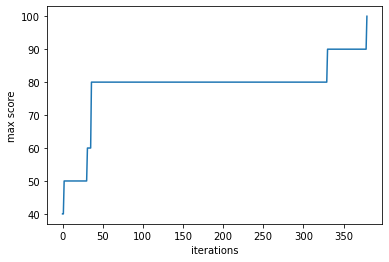

 38%|███████████████▏                        | 379/1000 [03:10<05:12,  1.99it/s]


In [ ]:
x_ds, y_ds = train_model(Tall=1000, num_reads=10, sampler=sampler, lam=0.01, alpha=30)

In [ ]:
print(len(y_ds))

390


390回の学習で、満点回答を探し出すことが出来ました!

### ランダム探索(世界史編)

ブラックボックス最適化との比較として、ランダムにデータ$\vec{x}$を作成させた場合も実行してみましょう。

In [ ]:
def random_search(
    Tall,
    x_dataset=x_dataset,
    y_dataset=y_dataset,
    num_variables=num_variables,
    num_questions=num_questions,
    num_options=num_options,
    max_score=100,
):
    x_ds = x_dataset.copy()
    y_ds = y_dataset.copy()
    y_max = []
    for time in tqdm(np.arange(Tall)):
        random_ans = np.zeros((num_questions, num_options))
        for ans in random_ans:
            random_number = np.random.choice([i for i in range(num_options)])
            ans[random_number] = 1
        random_ans = random_ans.flatten()
        if np.any(np.all(random_ans == np.array(x_ds), axis=1)):  # 既に調べた入力ならとばす
            continue

        # データセットの追加
        x_ds.append(random_ans)
        y = scoring(random_ans)
        y_ds.append(y)
        y_max.append(np.max([y, np.max(y_ds)]))

        clear_output(True)
        plt.xlabel("number of data")
        plt.ylabel("max score")
        plt.plot(y_max)
        plt.show()

        if np.max(y_max) == max_score:
            break

    return x_ds, y_ds

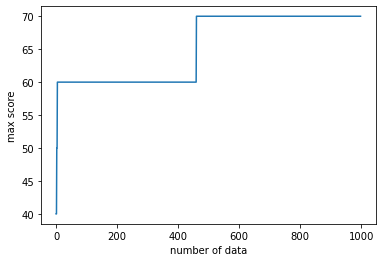

100%|███████████████████████████████████████| 1000/1000 [01:30<00:00, 11.09it/s]


In [ ]:
random_x, random_y = random_search(Tall=1000)

ランダムの場合でも、約500回で70点の解答を探し当てています。やはり、世界史のような4択問題では勘でも高得点が取れてしまいます。それでも、100点を探すには1000回以上の試行が必要であり、BOCSがいかに少ない回数で満点に到達できているかが分かります。

## 実験(数学編)

単純な4択問題では、1/4の確率で正解することが出来るため、実力以上の点数が取れてしまうこともあるでしょう。しかし、数学の場合そうはいきません。数学の採点は以下のように行われます。

<img src="figures/math_scorering_image.png" width="70%">

例のように、2問とも正解の場合に点数が入るため、世界史よりも難しい問題になっています。それでは、世界史編と同様にコードを書いていきましょう。

ここで注意点ですが、選択肢を{0, 1, 2, 3, -}の5択に調整しています。というのも、選択肢の数を増やすと変数の数が膨大になり、学習速度がかなり遅くなってしまうからです。今回は小さいサイズに調整して実験を行いましょう。

In [ ]:
# 数学の正解の番号,[-3, 12, -1, 10, 2]
correct_math_answer_str = ["-", "3", "1", "2", "-", "1", "1", "0", "2"]
set_indices_list = [[0, 1], [2, 3], [4, 5], [6, 7], [8]]

In [ ]:
options = ["0", "1", "2", "3", "-"]
num_math_questions = len(correct_math_answer_str)
num_math_options = len(options)
num_math_variables = num_math_options * num_math_questions
print("問題の数:", num_math_questions)
print("選択肢の数:", num_math_options)
print("変数の数:", num_math_variables)

問題の数: 9
選択肢の数: 5
変数の数: 45


In [ ]:
def ans_str2onehot_mat(
    answer_str,
    num_math_questions=num_math_questions,
    num_math_variables=num_math_variables,
    options=options,
):
    answer_index_list = [options.index(i) for i in answer_str]
    onehot_mat = np.zeros((num_math_questions, num_math_options))
    for i, j in enumerate(answer_index_list):
        onehot_mat[i, j] = 1
    return onehot_mat

正解のone-hot表現を見てみましょう。

In [ ]:
ans_str2onehot_mat(correct_math_answer_str)

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

続いて、初期データセットを作成します。

In [ ]:
def onehot_mat2ans_str(onehot_mat, options=options):
    answer_str = []
    for row in onehot_mat:
        index = list(row).index(1)
        answer_str.append(options[index])
    return answer_str

In [ ]:
def scoring_math(
    sample_mat,
    correct_math_answer_str=correct_math_answer_str,
    set_indices_list=set_indices_list,
):
    """
    採点を行う関数
    入力は、行列形式のx
    """
    question_score = 20
    total_score = 0
    ans_str = onehot_mat2ans_str(sample_mat)
    for set_indices in set_indices_list:
        result = True
        for index in set_indices:
            if correct_math_answer_str[index] != ans_str[index]:
                result = False
        if result == True:
            total_score += question_score
    return total_score

In [ ]:
def make_math_dataset(
    num_data, num_math_questions=num_math_questions, num_math_options=num_math_options
):
    x_dataset, y_dataset = [], []
    for _ in range(num_data):
        x = np.zeros((num_math_questions, num_math_options))
        for row in x:
            random_index = np.random.choice([i for i in range(num_math_options)])
            row[random_index] = 1
        y = scoring_math(x)
        x = x.flatten()
        x_dataset.append(x)
        y_dataset.append(y)
    return x_dataset, y_dataset

In [ ]:
x_math_dataset, y_math_dataset = make_math_dataset(num_data=10)

表示させてみましょう。

In [ ]:
print(x_math_dataset[0])
print("点数:", y_math_dataset[0])

[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
点数: 0


In [ ]:
def train_math_model(
    Tall,
    num_reads,
    sampler,
    lam,
    alpha,
    x_dataset=x_math_dataset,
    y_dataset=y_math_dataset,
    max_score=100,
    num_math_variables=num_math_variables,
    num_math_questions=num_math_questions,
    num_math_options=num_math_options,
):
    """
    エネルギー最小解のみをデータセットに加えて学習を行う
    """
    y_max = []
    x_ds = x_dataset.copy()
    y_ds = y_dataset.copy()
    # Xへの変換
    X_ds = [make_X(x, num_variables=num_math_variables) for x in x_ds]
    for time in tqdm(np.arange(Tall)):
        # aの推定
        a = predict_a(X_ds, y_ds, lam, num_variables=num_math_variables)
        # QUBOの更新
        QUBO = -makeQUBO(
            a=a,
            alpha=alpha,
            num_variables=num_math_variables,
            num_questions=num_math_questions,
            num_options=num_math_options,
        )  # 最大化問題なのでマイナス付ける
        # 獲得関数
        sampleset = sampler.sample_qubo(QUBO, num_reads=num_reads)
        lowest_sample = np.array([v for v in sampleset.first.sample.values()])
        lowest_sample = post_processing(
            lowest_sample,
            num_variables=num_math_variables,
            num_options=num_math_options,
        )

        # 新しいデータセットの追加
        y = scoring_math(lowest_sample.reshape((num_math_questions, num_math_options)))
        y_ds.append(y)
        y_max.append(np.max([y, np.max(y_ds)]))
        x_ds.append(np.array(lowest_sample))
        X_ds.append(make_X(lowest_sample, num_variables=num_math_variables))

        # プロット
        clear_output(True)
        plt.xlabel("iterations")
        plt.ylabel("max score")
        plt.plot(y_max)
        plt.show()

        if np.max(y_max) == max_score:
            break

    return x_ds, y_ds

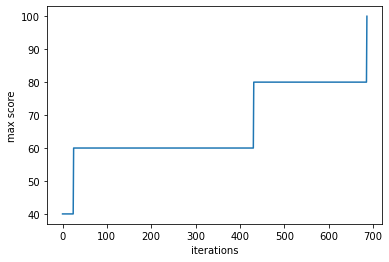

 34%|█████████████▋                          | 686/2000 [08:36<16:29,  1.33it/s]


In [ ]:
x_ds, y_ds = train_math_model(
    Tall=2000, num_reads=10, sampler=sampler, lam=0.01, alpha=10
)

約700回で満点を取ることが出来ました。変数の数が世界史の時よりも若干増えていますが、それを加味しても満点を取るのに必要な学習回数がかなり増えていることが分かります。それでは、ランダムの場合と比較してみましょう。

### ランダム探索(数学編)

In [ ]:
def random_math_search(
    Tall,
    x_dataset=x_math_dataset,
    y_dataset=y_math_dataset,
    num_variables=num_math_variables,
    num_questions=num_math_questions,
    num_options=num_math_options,
    max_score=100,
):
    x_ds = x_dataset.copy()
    y_ds = y_dataset.copy()
    y_max = []
    for time in tqdm(np.arange(Tall)):
        random_ans = np.zeros((num_questions, num_options))
        for ans in random_ans:
            random_number = np.random.choice([i for i in range(num_options)])
            ans[random_number] = 1
        random_ans = random_ans.flatten()
        if np.any(np.all(random_ans == np.array(x_ds), axis=1)):  # 既に調べた入力ならとばす
            continue

        # データセットの追加
        x_ds.append(random_ans)
        y = scoring_math(random_ans.reshape((num_math_questions, num_math_options)))
        y_ds.append(y)
        y_max.append(np.max([y, np.max(y_ds)]))

        # プロット
        clear_output(True)
        plt.xlabel("number of data")
        plt.ylabel("max score")
        plt.plot(y_max)
        plt.show()

        if np.max(y_max) == max_score:
            break

    return x_ds, y_ds

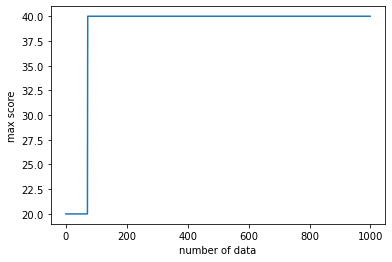

100%|███████████████████████████████████████| 1000/1000 [01:35<00:00, 10.51it/s]


In [ ]:
random_math_x, random_math_y = random_math_search(Tall=1000)

世界史では、ランダムでも70点に到達できていましたが、数学は2問しか正解できていません。これより、数学の代理関数の方がより難しい問題になっていると考えられます。

## あとがき

本記事では、ブラックボックス最適化にD-Waveマシンを使用し、実際の共通テストを解きました。本記事では、one-hot制約以外の部分を学習し、one-hot部分はQUBOに直接書くという手法を取りましたが、one-hot部分も同時に学習させるというパターンも実験しました。その場合、世界史の場合は約1200回の学習が必要になりました。学習に必要なデータは増えるものの、教えていない部分まで学習してくれるBOCSはかなり優秀だと感じました。

### 本記事の担当者

鹿内怜央